In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure,color,io,util,filters,feature
from skimage.color import rgb2gray

In [2]:
img1 = io.imread('C:/Users/juanr/Documents/mediciones_ZEISS/bandas/Banda2scenes/Banda2scenes_m007.png')
img = rgb2gray(img1)
img = util.invert(img)

In [3]:
pixels_to_microns = 0.586

C:\Users\juanr\Anaconda3\envs\defects\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


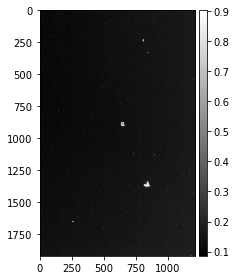

In [4]:
io.imshow(img,cmap='gray')

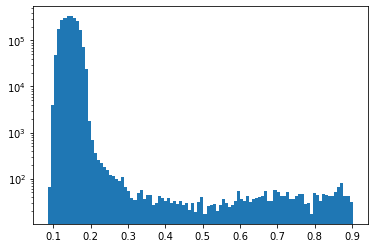

In [4]:
plt.hist(img.flatten(),bins=100,log=True);

In [ ]:
pixels_to_microns = 0.586

In [5]:
img = util.img_as_ubyte(img)
#blur = cv2.GaussianBlur(img,(5,5),0)
ret3,thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#ret1,thresh = cv2.threshold(img,90,255,cv2.THRESH_BINARY)

In [6]:
kernel = np.ones((3,3),np.uint8)

In [7]:
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,iterations=2)

In [8]:
from skimage.segmentation import clear_border
opening = clear_border(opening)

In [9]:
cv2.imshow('Opening image',opening)
cv2.waitKey(0)

48

In [10]:
sure_bg = cv2.dilate(opening,kernel,iterations=10)

In [11]:
cv2.imshow('Sure background',sure_bg)
cv2.waitKey(0)

48

In [12]:
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)

In [ ]:
cv2.imshow('Distance Transform',dist_transform)
cv2.waitKey(0)

In [19]:
ret2,sure_fg = cv2.threshold(dist_transform,0.001*dist_transform.max(),255,0)
sure_fg = np.uint8(sure_fg)

In [20]:
cv2.imshow('Sure Foreground',sure_fg)
cv2.waitKey(0)

48

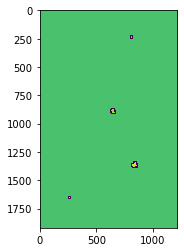

In [21]:
unknown = cv2.subtract(sure_bg,sure_fg)
ret3,markers = cv2.connectedComponents(sure_fg)
markers += 10
markers[unknown==255] = 0
plt.imshow(markers)

In [22]:
markers = cv2.watershed(img1,markers)

In [29]:
img1[markers==-1] = [0,255,255]
img2 = color.label2rgb(markers,bg_label=0)

In [39]:
cv2.imshow('Overlay on original image',img1)
cv2.imshow('Colored defects',img2)
cv2.waitKey(0)

48

In [30]:
from skimage.measure import regionprops_table
props = regionprops_table(markers,intensity_image= img,properties=['label','area','centroid','equivalent_diameter','extent'])
props

{'label': array([10, 11, 12, 13, 14]),
 'area': array([2325989,     143,     726,    1205,      61]),
 'centroid-0': array([ 959,  237,  890, 1363, 1650]),
 'centroid-1': array([607, 803, 642, 833, 257]),
 'equivalent_diameter': array([1720.91289013,   13.4934523 ,   30.40348515,   39.16955005,
           8.81292302]),
 'extent': array([0.99894222, 0.79444444, 0.70967742, 0.5998009 , 0.87142857])}

In [33]:
import pandas as pd  
data = pd.DataFrame(props)  
data['equivalent_diameter'] = data['equivalent_diameter']*pixels_to_microns
data['area'] = data['area']*pixels_to_microns*pixels_to_microns
data

,label,area,centroid-0,centroid-1,equivalent_diameter,extent
0,10,798735.318644,959,607,1008.454954,0.998942
1,11,49.105628,237,803,7.907163,0.794444
2,12,249.305496,890,642,17.816442,0.709677
3,13,413.792180,1363,833,22.953356,0.599801
4,14,20.947156,1650,257,5.164373,0.871429
